# Data Algorithms

## 1. K-Means Clustering

### 1.1 Description

As stated on Wikipedia
> Given a set of observations $(\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n)$, where each observation is a *d*-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k$ ($\leq n$) sets $\mathbf{S}= \{S_1, S_2, \ldots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (sum of distance functions of each point in the cluster to the K center). In other words, its objective is to find:
>
>$\begin{equation}\underset{\mathbf{S}} {\operatorname{arg\,min}}  \sum_{i=1}^{k} \sum_{\mathbf{x} \in S_i} \left\| \mathbf x - \boldsymbol\mu_i \right\|^2\end{equation}$
>
>where $\boldsymbol\mu_i$ is the mean of points in $S_i$.


### 1.2 Algorithm

1. Initialize cluster centroids $\boldsymbol\mu_1, \boldsymbol\mu_2, \ldots, \boldsymbol\mu_k \in \mathbb{R}^n$ randomly
2. Repeat until convergence:  
  2.1 For every $i$, set $y_i = \underset{j}{\arg\min} \|\mathbf{x}_i - \boldsymbol\mu_j\|^2$  
  2.2 For each $j$, set $\boldsymbol\mu_j = \frac{1}{\sum_i^n1\{y_i = j\}}\sum_i^n1\{y_i = j\}\mathbf{x}_i$

### 1.3 Objective

Write the k-means algorithm using [Spark's RDD API](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

### 1.4 Dataset

To test our algorithm, we will generate a 2D dataset using [scikit-learn](http://scikit-learn.org/stable/datasets/index.html#sample-generators). 

In [1]:
import numpy
from sklearn.datasets import make_blobs
from matplotlib import pyplot

In [2]:
N_SAMPLES = 10**3
N_FEATURES= 2
N_CENTERS = 4
STD = 1.0
BOX = (-50, 50)
features, tlabels = make_blobs(n_samples=N_SAMPLES,
                               n_features=N_FEATURES,
                               centers=N_CENTERS,
                               cluster_std=STD,
                               center_box=BOX)

We can visualize the clusters

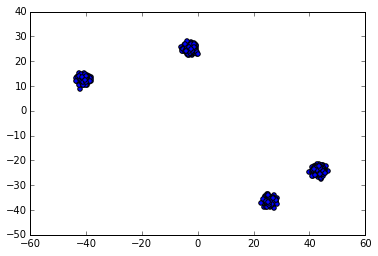

In [3]:
%matplotlib inline
pyplot.scatter(features[:, 0], features[:, 1])

We then create an RDD by parallelizing the features. Since, we will iterate on multiple time on the data, we will benefit from caching it in memory.

In [4]:
rdd = sc.parallelize(features).cache()

### 1.5 Implementation

In [5]:
def compute_label(point, centroids):
    """Return the label of the closest centroid.
    """
    return numpy.argmin([numpy.linalg.norm(point - c) for c in centroids])

In [6]:
def kmeans(rdd, n_centers, n_iter):
    # 0. Compute dataset bounding box
    min_ = rdd.reduce(lambda a, b: numpy.min((a, b), axis=0))
    max_ = rdd.reduce(lambda a, b: numpy.max((a, b), axis=0))
    
    # 1. Initialize cluster centroids    
    n_dim = len(min_)
    centroids = numpy.random.uniform(min_, max_, (n_centers, n_dim))

    # 2. Repeat until convergence
    seqOp = lambda a, b: (a[0] + b, a[1] + 1)
    combOp = lambda a, b: (a[0] + b[0], a[1] + b[1])
    for i in range(n_iter):
        # 2.1 Compute label for each points
        labels = rdd.map(lambda x: (compute_label(x, centroids), x))
        
        # 2.2 Compute the new centroids by label and collect them in a dictionnary
        centmap = labels.aggregateByKey((numpy.zeros(n_dim), 0), seqOp, combOp)\
                        .mapValues(lambda x: x[0] / x[1])\
                        .collectAsMap()
        
        # 2.3 Update the centroids in the numpy matrix
        for i in range(n_centers):
            if i in centmap:
                centroids[i, :] = centmap[i]
            else:
                # No point were associated centroid labeled `i`
                # Generate a new random one
                centroids[i, :] = numpy.random.uniform(min_, max_, n_dim)

    # 3. Return the final centroids
    return centroids

Test your algorithm on the dataset

In [7]:
kmeans(rdd, N_CENTERS, 20)

array([[-40.9427889 ,  12.759204  ],
       [ 25.54880078, -36.43006754],
       [ -2.93026135,  25.08557792],
       [ 43.2427717 , -24.0147544 ]])

### 1.6 Compare with MLlib Implementation

In [9]:
from pyspark.mllib.clustering import KMeans, KMeansModel

clusters = KMeans.train(rdd, N_CENTERS, maxIterations=20, initializationMode="random")
clusters.centers

[array([ 25.54880078, -36.43006754]),
 array([-40.9427889,  12.759204 ]),
 array([ 43.2427717, -24.0147544]),
 array([ -2.93026135,  25.08557792])]

## 2. Recommending Friends

This exercise draws heavily from Washington University course CS140: Data Programming's [Homework 4: Social networking and recommendation systems](https://courses.cs.washington.edu/courses/cse140/13wi/homework/hw4/homework4.html).

###  2.1 Description

Social network websites (Facebook, Twitter, LinkedIn) suggest person you should be connected (or friend) with. How do they do that?

A social network can be represented as a graph. Persons are represented as nodes or vertices, and the relationships are represented as edges. An edge between person A and person B means that A considers B a friend, and also B considers A a friend.

### 2.2 Objective

For user X, list some non-friends in order, starting with the best friend recommendation and ending with the worst.

### 2.3 Algorithm

If non-friend Y is your friend's friend, then maybe Y should be your friend too. If person Y is the friend of many of your friends, then Y is an even better recommendation. The best friend recommendation is the person with whom you have the largest number of mutual friends. You will implement this heuristic.

### 2.4 Dataset

In this exercise, you will start from the dataset "[Social characteristics of the Marvel Universe](http://bioinfo.uib.es/~joemiro/marvel.html)" which represents a list of relationships between characters in the [Marvel Universe](http://marvel.com/universe/Main_Page). 

From this dataset you should be able to infer a graph and determine friend recommendations.

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [ ]:
df = sqlContext.read.format('com.databricks.spark.csv')\
               .options(inferschema=False, header=False)\
               .load('data/marvel/hero-network.csv')\
               .distinct().cache()

### 2.5 Implementation

## 3. References

- [edX - Scalable Machine Learning Course](https://www.edx.org/course/scalable-machine-learning-uc-berkeleyx-cs190-1x)
- [edX - Scalable Machine Learnig Notebboks](https://github.com/spark-mooc/mooc-setup)